In [44]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error


%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')

import requests
import time
import datetime

In [45]:
CURRENCIES = {
    'Bitcoin' : 'BTC', 
    'Ethereum' : 'ETH', 
    'Litecoin' : 'LTC',
    'AdEx' : 'ADX', 
    'Substratum' : 'SUB',
    'Ripple' : 'XRP',
    'NEO' : 'NEO',
    'IOTA' : 'IOT',
    'Monero' : 'XMR',
             }
TARGET_CURRENCY = 'USD'

In [46]:
PRICE_HISTORY_BASE_URL = 'https://min-api.cryptocompare.com/data/histoday'
AGGREGATED_EXCHANGE = 'CCCAGG'
KRAKEN = 'KRAKEN'
NB_DAYS = 200
REQUEST_PARAMS = '?fsym={source_currency}&tsym={target_currency}&limit=' + str(NB_DAYS) + '&aggregate=1&e=' + KRAKEN # '&allData=1'
TEMPLATE_REQUEST_URL = PRICE_HISTORY_BASE_URL + REQUEST_PARAMS

In [47]:
# Obtain historical data from the beginning of time for each currency
currency_dataframe = {}
for currency, symbol in CURRENCIES.items():
    request_url = TEMPLATE_REQUEST_URL.format(source_currency = symbol, target_currency = TARGET_CURRENCY)
    print('Fetching historical market data for {} ({} -> {}) ....'.format(currency, symbol, TARGET_CURRENCY))
    print('Request URL :', request_url)
    json_response = requests.get(url = request_url).json()
    if json_response['Response'] == 'Error':
        print('Failed to fetch historical market data for {} ({} -> {}) !, Error Message : {}'
              .format(currency, symbol, TARGET_CURRENCY, json_response['Message']))
    else:
        # print(json_response)
        df = pd.DataFrame(json_response['Data'])
        # convert time (unix timestamp) to date
        df['date'] = pd.to_datetime(df['time'], unit = 's')
        # drop time column
        df.drop('time', axis = 1, inplace = True)
        # set date column as index
        df.set_index('date', inplace = True)
        
        # volumefrom : trading volume of source currency traded (ex: BTC)
        # volumeto : trading volume of target currency traded (ex: USD)
        # average price of 1 unit of the source currency in the target currency = volumeto / volumefrom
        df.rename(columns = {'open': 'market_open', 'close': 'market_close',
                             'low': 'market_low', 'high': 'market_high',
                             'volumefrom': 'trading_volume_source_currency', 
                             'volumeto': 'trading_volume_target_currency'}, inplace = True)
        currency_dataframe[currency] = df
        print('Successfully fetched historical market data for {} !'.format(currency, symbol))
    # sleep for 1s to avoid hitting max rate limit per second
    time.sleep(1)
        

Fetching historical market data for Bitcoin (BTC -> USD) ....
Request URL : https://min-api.cryptocompare.com/data/histoday?fsym=BTC&tsym=USD&limit=200&aggregate=1&e=KRAKEN
Successfully fetched historical market data for Bitcoin !
Fetching historical market data for Ethereum (ETH -> USD) ....
Request URL : https://min-api.cryptocompare.com/data/histoday?fsym=ETH&tsym=USD&limit=200&aggregate=1&e=KRAKEN
Successfully fetched historical market data for Ethereum !
Fetching historical market data for Litecoin (LTC -> USD) ....
Request URL : https://min-api.cryptocompare.com/data/histoday?fsym=LTC&tsym=USD&limit=200&aggregate=1&e=KRAKEN
Successfully fetched historical market data for Litecoin !
Fetching historical market data for AdEx (ADX -> USD) ....
Request URL : https://min-api.cryptocompare.com/data/histoday?fsym=ADX&tsym=USD&limit=200&aggregate=1&e=KRAKEN
Failed to fetch historical market data for AdEx (ADX -> USD) !, Error Message : e param is not valid the market does not exist for th

In [48]:
def plot_bollinger(currency, df):
    # set style, empty figure and axes
    # plt.style.use('fivethirtyeight')
    fig = plt.figure(figsize=(12,6))
    ax = fig.add_subplot(111)

    # Get index values for the X axis for DataFrame
    x_axis = df.index.get_level_values(0)

    # Plot shaded 21 Day Bollinger Band
    ax.fill_between(x_axis, df['upper_band'], df['lower_band'], color='grey')

    # Plot Price and Moving Averages
    ax.plot(x_axis, df[price_column], color='blue', lw=2)
    ax.plot(x_axis, df['mean_' + price_column], color='black', lw=2)

    # Set Title & Show the Image
    ax.set_title(str(window_size) + ' Day Bollinger Band For ' + currency)
    ax.set_xlabel('Date (Year/Month)')
    ax.set_ylabel('Price (' + TARGET_CURRENCY + ')')
    ax.legend()
    plt.show();

In [62]:
BUY = 2
SELL = 1
KEEP = 0

def evaluate(df, decision_col = 'decision'):
    '''
    Evaluation of gains/losses based on the buy/sell/keep logic
    Assumptions : no partial buys or sells, meaning we always 
     * sell all holdings for the given cryptocurrency to obtain a target fiat currency
     * buy the equivalent in the target cryptocurrency of the available fiat currency
    It is important to note that gains/losses could also be affected by fluctuations in the value of 
    the fiat currency used. We are ignoring these variations for now as fiat currencies are usually less volatile.
    It might be interesting to look at fiat currency variations when looking to buy/sell/keep.
    '''
    # market_close, amount crypto, amount fiat, total holdings fiat, net gains/losses in fiat (0 on the 1st day)
    # Initialize crypto_holdings and fiat_holdings on DAY 1
    # We assume 1 unit of the cryptocurrency was bought and there were no fiat holdings left after the 1st purchase
    df['crypto_holdings'] = 1
    df['fiat_holdings'] = 0
    
    # Compute crypto_holdings and fiat_holdings based on keep/sell/buy decisions
    # Remember : we always buy or sell all, no partial transactions
    for i in range(1, df.shape[0]):
        today = df.iloc[i]
        yesterday = df.iloc[i - 1]
        
        crypto_holdings = yesterday['crypto_holdings']
        fiat_holdings = yesterday['fiat_holdings']
        
        # KEEP
        if today[decision_col] == KEEP:
            pass
            
        # SELL
        elif today[decision_col] == SELL:
            # sell all crypto holdings
            crypto_holdings = 0
            fiat_holdings += yesterday['crypto_holdings'] * today['market_close'] 
          
        # BUY
        else:
            # buy the equivalent of all fiat holdings
            crypto_holdings += yesterday['fiat_holdings'] / today['market_close']
            fiat_holdings = 0 
            
        today['crypto_holdings'] = crypto_holdings
        today['fiat_holdings'] = fiat_holdings
        df.iloc[i] = today
        
        # df['crypto_holdings'] = df.apply(lambda row: row['crypto_holdings'] if row[decision_col] == KEEP else 0 if row[decision_col] == SELL else row['fiat_holdings'] / row['market_close'], axis = 1)
        # df['fiat_holdings'] = df.apply(lambda row: row['fiat_holdings'] if row[decision_col] == KEEP else row['crypto_holdings'] * row['market_close'] if row[decision_col] == SELL else 0, axis = 1)
    
    df['total_holdings_in_fiat'] = df['crypto_holdings'] * df['market_close'] + df['fiat_holdings']
    df['net_gain'] = df['total_holdings_in_fiat'] - df['total_holdings_in_fiat'].shift(1)
    df['cumulative_gain'] = df['net_gain'].cumsum()
    total_gain = df['net_gain'].sum()
    return (total_gain, df.copy())

In [63]:
price_column = 'market_close'
window_size = 21
band_multiplier = 2

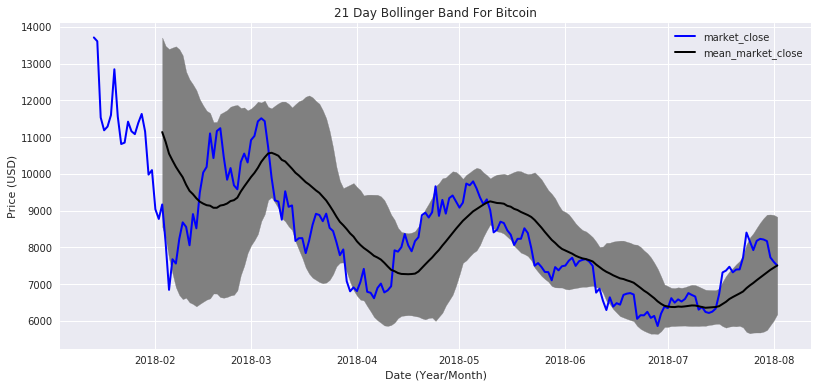

-----------KEEP ALL TIME ---------------
(KEEP) Net gains : -6205.000000000001
-----------RANDOMIZED DECISIONS ---------------


/home/condauser/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/condauser/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/condauser/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


(RANDOMIZED) Net gains : -2591.72174820689


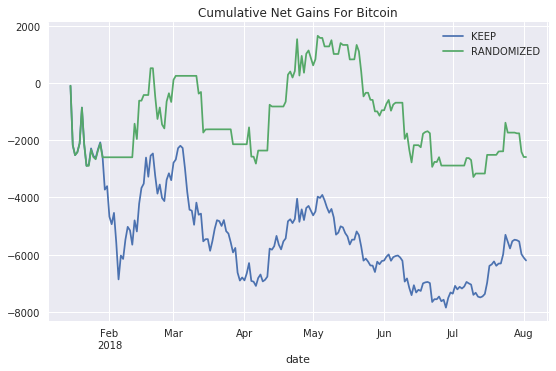

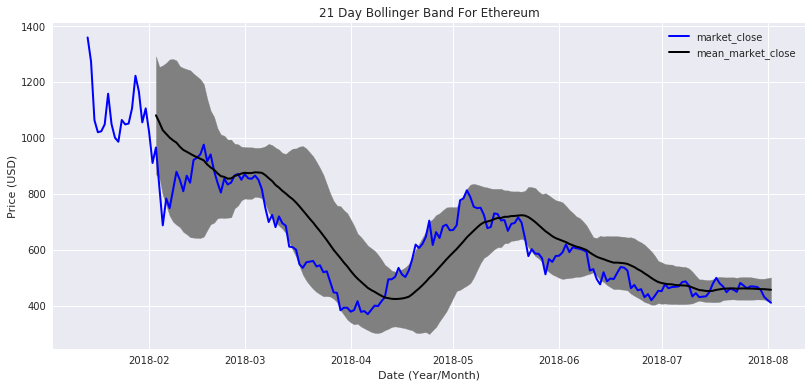

-----------KEEP ALL TIME ---------------
(KEEP) Net gains : -948.53
-----------RANDOMIZED DECISIONS ---------------
(RANDOMIZED) Net gains : -335.16492171083644


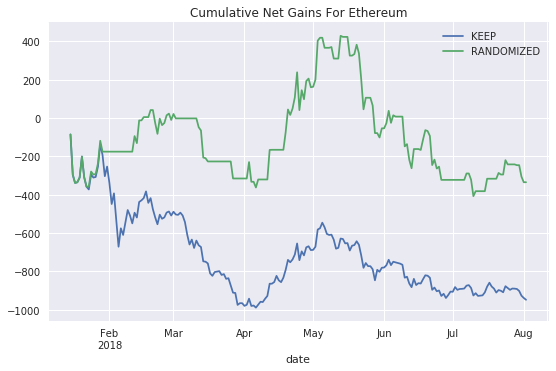

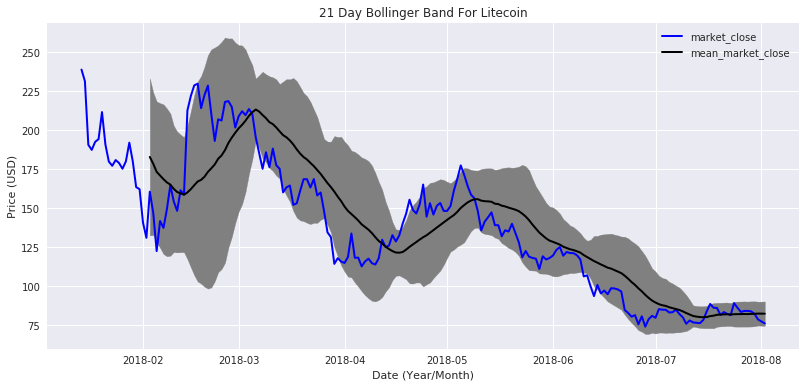

-----------KEEP ALL TIME ---------------
(KEEP) Net gains : -162.82
-----------RANDOMIZED DECISIONS ---------------
(RANDOMIZED) Net gains : -103.8893243238542


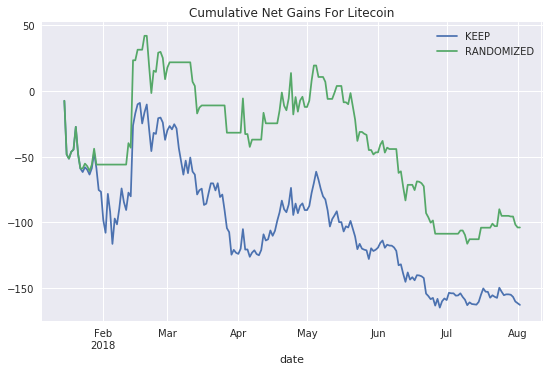

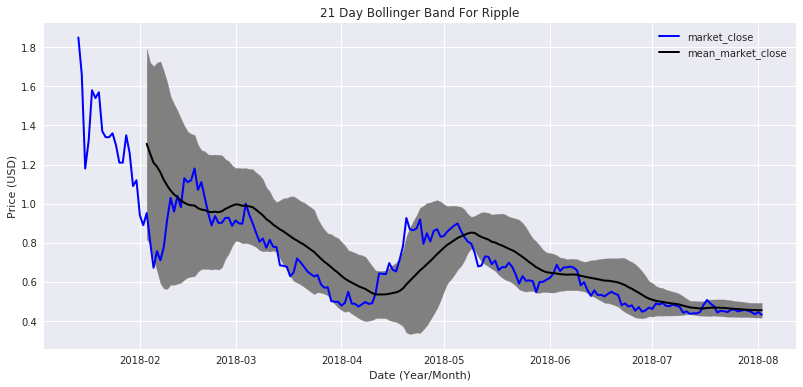

-----------KEEP ALL TIME ---------------
(KEEP) Net gains : -1.4181000000000001
-----------RANDOMIZED DECISIONS ---------------
(RANDOMIZED) Net gains : -0.8389303550093286


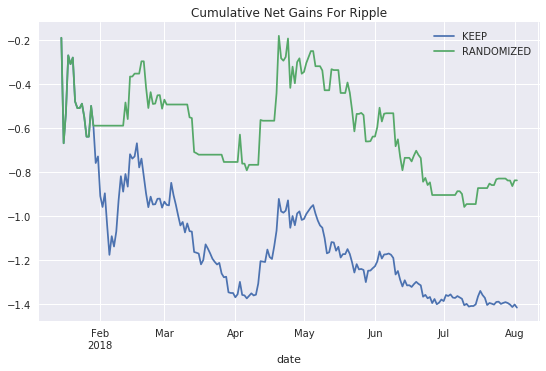

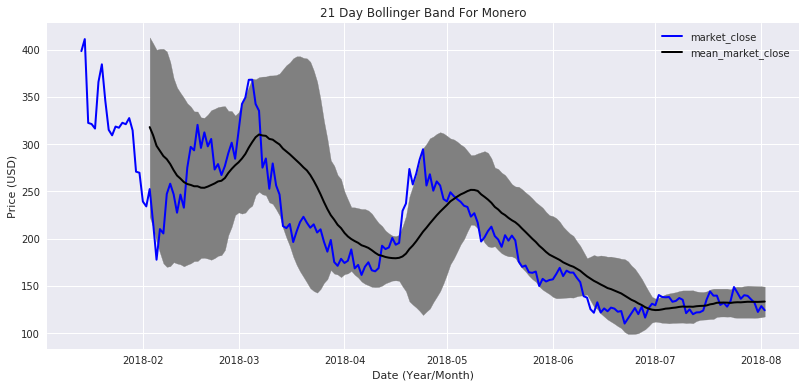

-----------KEEP ALL TIME ---------------
(KEEP) Net gains : -274.33
-----------RANDOMIZED DECISIONS ---------------
(RANDOMIZED) Net gains : -159.27843394505732


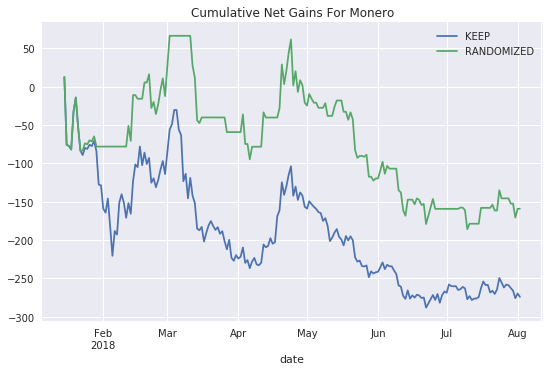

In [65]:
# Compute and Plot Bolligner Bands for all currencies
for currency, df in currency_dataframe.items():
    df['mean_' + price_column] = df[price_column].rolling(window=window_size).mean()
    df['std_' + price_column] = df[price_column].rolling(window=window_size).std()
    df['upper_band'] = df['mean_' + price_column] + band_multiplier * df['std_' + price_column]
    df['lower_band'] = df['mean_' + price_column] - band_multiplier * df['std_' + price_column]
    
    # Plot bollinger bands
    plot_bollinger(currency, df)
    
    print('-----------KEEP ALL TIME ---------------')
    df['decision'] = KEEP
    
    # Evaluate net gains
    total_gain, new_df_keep = evaluate(df)
    print('(KEEP) Net gains : {}'.format(str(total_gain)))
    
    print('-----------RANDOMIZED DECISIONS ---------------')
    # Keep 1st day
    df['decision'] = KEEP
    
    np.random.seed(42)
    df['decision'].iloc[1:] = np.random.randint(0, 3, df.shape[0] - 1)
    # print(df.head())
    
    # Evaluate net gains
    total_gain, new_df_random = evaluate(df)
    print('(RANDOMIZED) Net gains : {}'.format(str(total_gain)))
    
    new_df = pd.concat([new_df_keep['cumulative_gain'], new_df_random['cumulative_gain']], axis=1, keys=['KEEP', 'RANDOMIZED'])
    new_df[['KEEP', 'RANDOMIZED']].plot(title = 'Cumulative Net Gains For ' + currency)

In [5]:
df = currency_dataframe['Bitcoin']

In [6]:
df.head()

,market_close,market_high,market_low,market_open,trading_volume_source_currency,trading_volume_target_currency
date,,,,,,
2018-01-08,15022.6,16130.1,14259.9,16128.4,3434.09,52090600.04
2018-01-09,14516.6,15440.7,14230.7,15022.6,2992.06,44550151.16
2018-01-10,14937.6,14979.0,13525.0,14516.6,3396.59,48191581.71
2018-01-11,13503.4,15055.0,12848.0,14937.6,1991.54,27096334.20
2018-01-12,13503.4,13503.4,13503.4,13503.4,0.00,0.00


In [7]:
df.describe()

,market_close,market_high,market_low,market_open,trading_volume_source_currency,trading_volume_target_currency
count,201.000000,201.000000,201.000000,201.000000,201.000000,2.010000e+02
mean,8588.321393,8916.079104,8248.006965,8632.316915,6774.115174,5.812430e+07
std,1897.076726,2039.942005,1776.779671,1981.987818,4504.134216,3.857976e+07
min,5858.600000,6161.100000,5650.000000,5858.600000,0.000000,0.000000e+00
25%,7080.100000,7447.900000,6773.900000,7080.100000,3636.800000,2.854193e+07
50%,8233.800000,8500.000000,7902.000000,8248.600000,5351.460000,4.840898e+07
75%,9526.200000,9799.900000,9165.000000,9580.000000,9117.070000,8.087972e+07
max,15022.600000,16130.100000,14259.900000,16128.400000,28799.430000,1.951901e+08


In [8]:
df.shape

(201, 6)

In [9]:
current_date = datetime.datetime.now().strftime("%Y-%m-%d")
current_date

'2018-07-27'

In [19]:
df['mean_' + price_column] = df[price_column].rolling(window=window_size).mean()
df['std_' + price_column] = df[price_column].rolling(window=window_size).std()
df['upper_band'] = df['mean_' + price_column] + band_multiplier * df['std_' + price_column]
df['lower_band'] = df['mean_' + price_column] - band_multiplier * df['std_' + price_column]

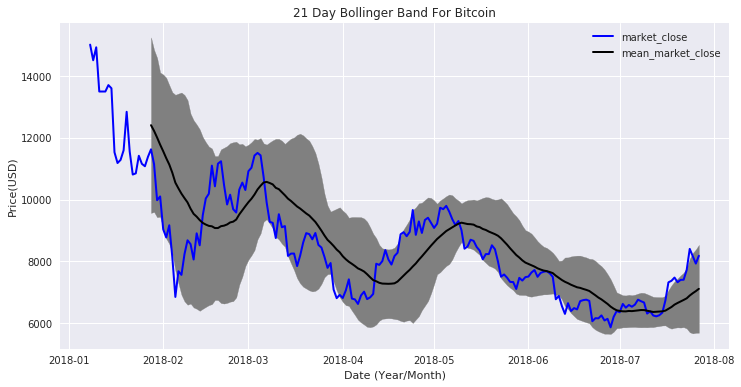

In [22]:
# set style, empty figure and axes
# plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)

# Get index values for the X axis for DataFrame
x_axis = df.index.get_level_values(0)

# Plot shaded 21 Day Bollinger Band
ax.fill_between(x_axis, df['upper_band'], df['lower_band'], color='grey')

# Plot Price and Moving Averages
ax.plot(x_axis, df[price_column], color='blue', lw=2)
ax.plot(x_axis, df['mean_' + price_column], color='black', lw=2)

# Set Title & Show the Image
ax.set_title(str(window_size) + ' Day Bollinger Band For Bitcoin')
ax.set_xlabel('Date (Year/Month)')
ax.set_ylabel('Price (' + TARGET_CURRENCY + ')')
ax.legend()
plt.show();